In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy as sp
from scipy import signal as sp_signal
import biosignalsnotebooks as bsnb
from statistics import mode
import pickle
from hmmlearn import hmm
from sklearn.preprocessing import normalize

In [2]:
def open_file(archivo):
    df = pd.read_csv(archivo, sep='\t', header=None)
    df.columns = ['Time', 'C 1', 'C 2', 'C 3', 'C 4', 'Timestamp', 'Lecture code', 'Dummy']
    unwanted = ['C 2', 'C 4']
    del df['Dummy']
    for column in unwanted:
        del df[column]
    return df

In [3]:
class SignalProcessing:
    def __init__(self, df, columnas):
        self.df = df
        self.columnas = columnas
        self.matriz = None
        self.periodos = None
        self.psd_matriz = None
        self.signals = None

    def apply_emg_filter(self):
        for columna in self.columnas:   
            self.df[columna], _, _ = self.filter_emg(self.df[columna])

    def filter_emg(self, emg, low_pass=10, sfreq = 256, high_band = 4, low_band = 40):
        # Normalize cut off freq to sampling freq
        high_band = high_band/(sfreq/2)
        low_band = low_band/(sfreq/2)

        # Create bandpass filter for emg
        b1, a1 = sp.signal.butter(4, [high_band, low_band], btype='bandpass')

        # process emg signal: filter emg
        emg_filtered = sp.signal.filtfilt(b1,a1,emg)

        # Process emg signal recify
        emg_rectified = abs(emg_filtered)

        # low pass filter and apply to rectified signal to get emg envelope
        low_pass = low_pass/(sfreq/2)
        b2, a2 = sp.signal.butter(4, low_pass, btype='lowpass')
        emg_envelope= sp.signal.filtfilt(b2, a2, emg_rectified)
        return emg_filtered, emg_rectified, emg_envelope

    def get_periodos(self, per_time = False): # List[Tuple[int]]
        lecture_codes = self.df['Lecture code'].values
        times = self.df['Time'].values
        periodos = []
        size = len(times)
        active_signal = False
        current_period = []
        for i in range(size):
            code = int(lecture_codes[i])
            time = int(times[i])
            append = i if not per_time else times[i]

            if code>=100 and code <=110:
                active_signal = True

            if active_signal and len(current_period)==0:
                current_period.append(append) # time

            if code >= 200 and active_signal:
                active_signal = False
                current_period.append(append) # time
                periodos.append(tuple(current_period))
                current_period = []
        self.periodos = periodos
        return self.periodos
    
    def get_elements_per_window(self): # int
        if  self.periodos:
            self.get_periodos()
        periodos = self.periodos
        difs = []
        for init,end in periodos:
            diferencia = end - init
            difs.append(diferencia)
        return mode(difs)
    
    def get_all_periods(self, periodos):
        last_end = -1
        new_periodos = []
        for i in range(len(periodos)): #asumiendo que nunca empezamos en 0
            init,end = periodos[i]
            new_period = [last_end+1, init]
            last_end = end
            new_periodos.append(new_period)
            new_periodos.append(periodos[i])
        return new_periodos

    def create_matriz(self, size_ventana = 15, all_p = False):
        df = self.df
        columnas = self.columnas
        lecture_codes = self.df['Lecture code'].values
        periodos = self.get_periodos() #periodos con codigos.. 101 102 5000 9000
        elements_per_second = self.get_elements_per_window()
        matriz = {} # signal_code: columnas x time x epochs
        elementos_por_ventana = int(elements_per_second*size_ventana/15)
        all_periods = self.get_all_periods(periodos)# [5000 9000] [0 5000, 5000 9000, 90001 ...]
        periodos = all_periods if all_p else periodos
        for nombre_columna in columnas:
            columna = df[nombre_columna].values
            epochs = []
            epochs_per_signal = {}
            for init,end in periodos:
                current_epoch = []
                current_signal = lecture_codes[init]
                for i in range(init,end):
                    freq = columna[i]
                    current_epoch.append(freq)
                    if len(current_epoch) == elementos_por_ventana:
                        if current_signal not in epochs_per_signal:
                            epochs_per_signal[current_signal] = []
                        epochs_per_signal[current_signal].append(current_epoch)
                        epochs.append(current_epoch)
                        current_epoch = []
#             At this point we have epochs_per_signal like this, for just 1 chanel
#             101: [[],[]]
#             102: [[],[]]
            for signal,epochs in epochs_per_signal.items():
                if signal not in matriz:
                    matriz[signal] = []
                matriz[signal].append(epochs) #agregamos los epochs del canal de la señal
        self.matriz = matriz
    
    def generate_psd_matrix(self):
        psd_matriz = {}
        for signal,canales in self.matriz.items():
            current_matriz = []
            for canal in canales:
                cnl = []
                for epoch in canal:
                    freqs, psd = sp_signal.periodogram(epoch, 256) # fs
                    cnl.append(psd)
                current_matriz.append(cnl)
            # current matriz tiene la info de una señal
            psd_matriz[signal] = current_matriz
        self.psd_matriz = psd_matriz

    def create_df(self):
        rows_matriz = []
        for signal,canales in self.psd_matriz.items():
            current_epoch = 0
            total_epochs = len(canales[0])
            while(current_epoch<total_epochs):
                epoch_per_signal = []
                for canal in canales:
                    epoch_per_signal.extend(canal[current_epoch])
                epoch_per_signal.append(signal)
                rows_matriz.append(epoch_per_signal)  
                current_epoch+=1
        self.df_psd = pd.DataFrame.from_records(rows_matriz)
    
    def plot_df(self, canales, init = None, end = None):
        self.df.iloc[init:end].plot(x='Time', y=canales, figsize=(20,8))

### Pre procesamiento de la señan para entrenar nuestro ´clasificador´

We have 4 chanels, we want to use C1 and C3 since they are the ones who tells us insides about the signals

Lecture code is the activity done.
Activity signal: 100.... 199
If we found a 10x, this means at this time our activity starts, if we found a 20x, this means our activity stops
 <pre>
0 0 0 0 101 0 0 0 0 0 200 0 0 0 0\
         |             |\
    Activity starts    Stops 
 <pre>
 
 So we want to be able to classify those active signals with high accuracy

In [4]:
size_window = .2
canales = ['C 1', 'C 3']
archivo = 'Izquierda - Derecha - Cerrado 1.txt'
df = open_file(archivo)
df.head()

,Time,C 1,C 3,Timestamp,Lecture code
0,0.000000,-17.213388,-3.959528,1.600423e+12,0
1,0.003906,-1.411259,-5.499511,1.600423e+12,0
2,0.007812,43.181385,-0.561774,1.600423e+12,0
3,0.011719,57.539547,3.926640,1.600423e+12,0
4,0.015625,3.823523,1.838967,1.600423e+12,0


In [5]:
signal_processing = SignalProcessing(df, canales)

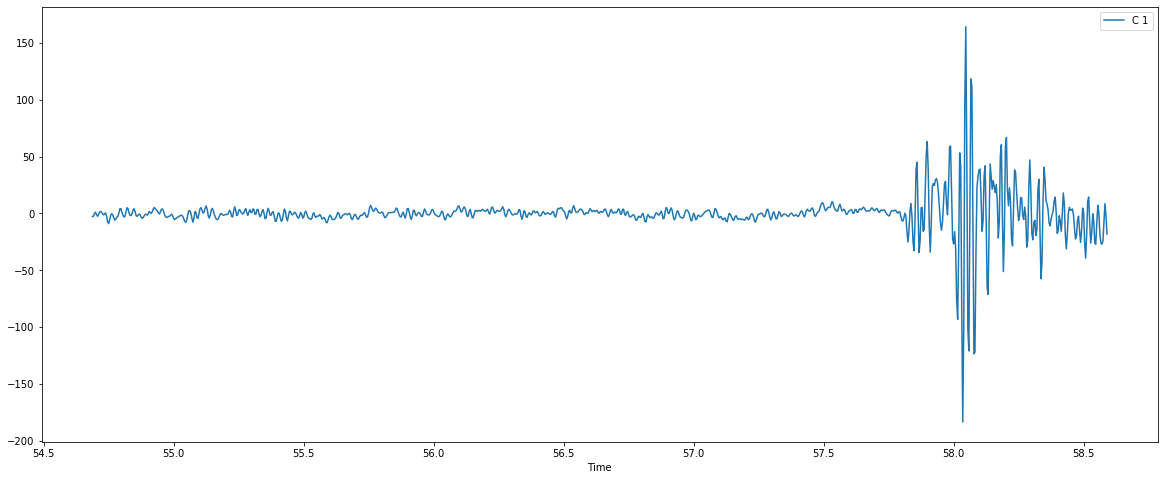

In [6]:
signal_processing.plot_df(['C 1'], 14000, 15000)

Aplicamos un filtro al emg, para cada canal hacemos un pasabanda de la signal que nos interesa

In [7]:
signal_processing.apply_emg_filter()

In [8]:
signal_processing.df.head()

,Time,C 1,C 3,Timestamp,Lecture code
0,0.000000,0.180420,-0.536715,1.600423e+12,0
1,0.003906,36.072495,1.873235,1.600423e+12,0
2,0.007812,49.487203,3.505922,1.600423e+12,0
3,0.011719,34.852487,3.641570,1.600423e+12,0
4,0.015625,8.286470,2.019936,1.600423e+12,0


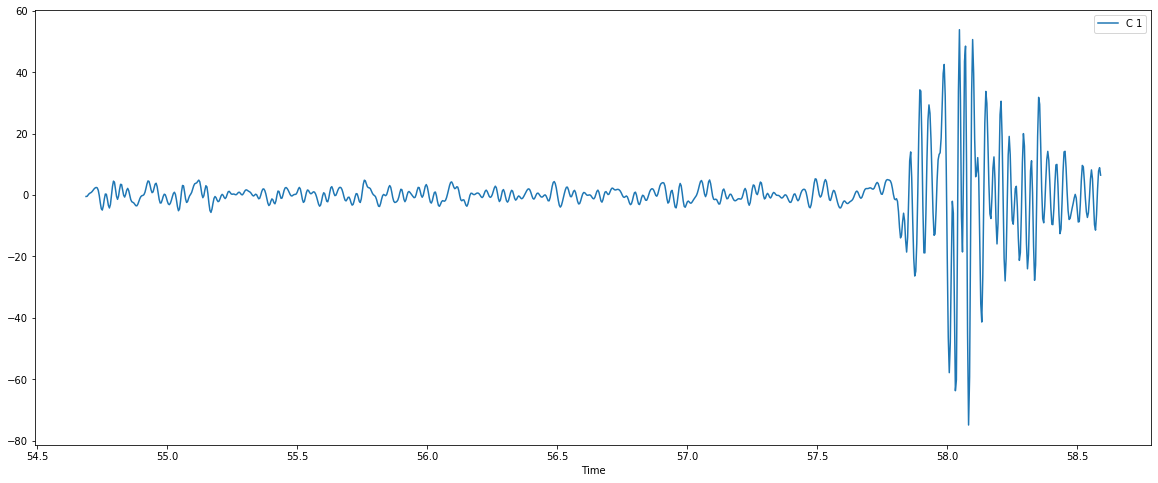

In [9]:
signal_processing.plot_df(['C 1'], 14000, 15000)

Ahora queremos tener nuestros datos divididos por señal, por canal y por epoch (duración de nuestra ventana)

Entonces estamos generando un diccionario con el formato:
 <pre>
{
    101: [
            [[1.1, 1.2, 1.3...], [1.2, 1.3, 1.4...]], # Canal 1, tiene 2 epochs en este ejemplo
            [[1.1, 1.2, 1.3...], [1.2, 1.3, 1.4...]]  # Canal 2, tiene 2 epochs en este ejemplo
        ]
    102: ....
}
 <pre>
Entonces todo lo que tenemos en 101, son señales del evento 101, separado por canal y por epoch, el epoch fue hecho calculando la cantidad de elementos deseados en el periodo de tiempo dicho

In [10]:
signal_processing.create_matriz(size_window)

In [11]:
signal_processing.matriz.keys()

dict_keys([101, 103, 102])

In [12]:
len(signal_processing.matriz[101]), len(signal_processing.matriz[101][0]),  len(signal_processing.matriz[101][0][0])

(2, 450, 51)

Tenemos 2 canales con 450 epochs que duran .2 segundos, esto es 51 elementos del df, esto para cada una de nuestras señales, que son 101, 103, 102 y 0

Ahora que que tenemos nuestros epochs separados, queremos transformar la señal que tenemos para poder usarla y crear nuestro "clasificador".
Queremos obtener el PSD, Power Spectral Density, de la señal, la cual describe el poder presente en función de la frecuencia por unidad de frecuencia, entonces a cada epoch le aplicamos un filtro de PSD

In [13]:
signal_processing.generate_psd_matrix()

Comparemos la matriz sin psd y con psd

In [14]:
data = {'No PSD':signal_processing.matriz[101][0][0][:10],
        'PSD':signal_processing.psd_matriz[101][0][0][:10]}
df_psd_tmp = pd.DataFrame(data)
df_psd_tmp

,No PSD,PSD
0,-0.153660,1.142341e-34
1,0.040158,2.113359e-02
2,0.279784,4.224753e-02
3,0.778377,1.872044e-02
4,1.477685,1.532387e-01
5,1.929150,5.653796e-02
6,1.580263,1.281858e-02
7,0.281111,3.991137e-02
8,-1.428693,2.131640e-02
9,-2.563328,4.667200e-03


Finalmente para tener nuestros datos listos, necesitamos tenerlos en otro formato. Actualmente lo tenemos estructurado pero ahora lo necesitamos de la manera X y, como para un clasificador

Entonces, estamos de acuerdo en que los diferentes canales para una misma señal comparten la señal.. por ejemplo
<pre>
C1. C2 Lecture
1   2    101
1   2    0
1   2    0
0.  0.   200

C1 y C2 pertenecen a la misma señal de 101, pero son diferentes señales, son diferentes canales, podemos verlo como diferentes señales pero que hablan de la misma señal, entonces queremos juntarlas

Lo que haremos será crear un df con la forma

Canal 1 + Canal 3 + .. +  Canal N | Valor, siendo valor 101 por ejemplo

In [15]:
signal_processing.create_df()

In [16]:
signal_processing.df_psd.head()

,0,1,2,3,4,5,6,7,8,9,...,43,44,45,46,47,48,49,50,51,52
0,1.142341e-34,0.021134,0.042248,0.018720,0.153239,0.056538,0.012819,0.039911,0.021316,0.004667,...,0.000299,0.000278,0.000262,0.000249,0.000239,0.000231,0.000225,0.000222,0.000220,101
1,1.510533e-35,0.511206,0.135747,0.214426,0.057022,0.097690,0.025796,0.201940,0.029280,0.002306,...,0.000420,0.000393,0.000372,0.000354,0.000341,0.000330,0.000323,0.000318,0.000316,101
2,0.000000e+00,0.341286,0.280890,0.224551,0.365130,0.134873,0.055329,0.002446,0.003636,0.001134,...,0.000331,0.000284,0.000249,0.000224,0.000205,0.000191,0.000182,0.000176,0.000173,101
3,3.776333e-36,0.096983,0.009131,0.041878,0.025238,0.087390,0.004583,0.082856,0.038574,0.007825,...,0.000138,0.000126,0.000117,0.000110,0.000105,0.000101,0.000098,0.000096,0.000095,101
4,1.720592e-34,0.095673,0.527565,0.010894,0.113393,0.058851,0.180729,0.052457,0.013758,0.000690,...,0.000109,0.000096,0.000086,0.000078,0.000073,0.000069,0.000066,0.000064,0.000064,101


In [17]:
signal_processing.df_psd[signal_processing.df_psd[52]==101].head()

,0,1,2,3,4,5,6,7,8,9,...,43,44,45,46,47,48,49,50,51,52
0,1.142341e-34,0.021134,0.042248,0.018720,0.153239,0.056538,0.012819,0.039911,0.021316,0.004667,...,0.000299,0.000278,0.000262,0.000249,0.000239,0.000231,0.000225,0.000222,0.000220,101
1,1.510533e-35,0.511206,0.135747,0.214426,0.057022,0.097690,0.025796,0.201940,0.029280,0.002306,...,0.000420,0.000393,0.000372,0.000354,0.000341,0.000330,0.000323,0.000318,0.000316,101
2,0.000000e+00,0.341286,0.280890,0.224551,0.365130,0.134873,0.055329,0.002446,0.003636,0.001134,...,0.000331,0.000284,0.000249,0.000224,0.000205,0.000191,0.000182,0.000176,0.000173,101
3,3.776333e-36,0.096983,0.009131,0.041878,0.025238,0.087390,0.004583,0.082856,0.038574,0.007825,...,0.000138,0.000126,0.000117,0.000110,0.000105,0.000101,0.000098,0.000096,0.000095,101
4,1.720592e-34,0.095673,0.527565,0.010894,0.113393,0.058851,0.180729,0.052457,0.013758,0.000690,...,0.000109,0.000096,0.000086,0.000078,0.000073,0.000069,0.000066,0.000064,0.000064,101


Entonces tenemos un array bidimensional donde cada row es un epoch de de .2 segundos, siendo la suma de sus canales que nos interesan, y nuestra ultima columna es la señal a la que pertenece

### Clasificador

Primero, vamos a adoptar un approach en donde no nos preocupamos por nuestras transiciones de estado.

Lo que haremos será crear una cadena para cada tipo de código y después, para probarlo, vamos a obtener el Maximum Likelihood Estimate entre todos los modelos, y nos quedaremos con el de mayor valor

In [18]:
codes = list(signal_processing.psd_matriz.keys())

hmm_models = []
df_psd = signal_processing.df_psd
last_index = df_psd.shape[1]-1
for code in codes:
    current_df = df_psd[df_psd[last_index]==code]
    current_X = current_df.iloc[:,:-1].values
    clf = hmm.GaussianHMM(n_components=1,covariance_type='diag',n_iter=1000)
    clf.fit(current_X)
    hmm_models.append((clf, code))

In [19]:
hmm_models

[(GaussianHMM(n_iter=1000), 101),
 (GaussianHMM(n_iter=1000), 103),
 (GaussianHMM(n_iter=1000), 102)]

Debido a que el propósito de este proyecto es para procesamiento de señales en tiempo real, vamos a hacer una simulación de lo que sería procesar en tiempo real estos datos.
A continuación creo una clase específica para estos datos, en donde aplico el EMG y le aplico PSD únicamente, dado que todo lo que reciba será un epoch completo, entonces no necesito separar por tipos de señales o canales

In [20]:
class SignalProcessingOnline:

    def __init__(self, df, columnas):
        self.df = df
        self.columnas = columnas

    def apply_emg_filter(self):
        for columna in self.columnas:   
            self.df[columna], _, _ = self.filter_emg(self.df[columna])

    def filter_emg(self, emg, low_pass=10, sfreq = 256, high_band = 4, low_band = 40):
        high_band = high_band/(sfreq/2)
        low_band = low_band/(sfreq/2)
        b1, a1 = sp.signal.butter(4, [high_band, low_band], btype='bandpass')
        emg_filtered = sp.signal.filtfilt(b1,a1,emg)
        emg_rectified = abs(emg_filtered)
        low_pass = low_pass/(sfreq/2)
        b2, a2 = sp.signal.butter(4, low_pass, btype='lowpass')
        emg_envelope= sp.signal.filtfilt(b2, a2, emg_rectified)
        return emg_filtered, emg_rectified, emg_envelope

    def get_periodos(self, per_time = False):
        lecture_codes = self.df['Lecture code'].values
        times = self.df['Time'].values
        periodos = []
        size = len(times)
        active_signal = False
        current_period = []
        for i in range(size):
            code = int(lecture_codes[i])
            time = int(times[i])
            append = i if not per_time else times[i]

            if code>=100 and code <=110:
                active_signal = True

            if active_signal and len(current_period)==0:
                current_period.append(append) # time

            if code >= 200 and active_signal:
                active_signal = False
                current_period.append(append) # time
                periodos.append(tuple(current_period))
                current_period = []
        self.periodos = periodos
        return self.periodos

    def process_data(self):
        new_epochs = []

        for canal in self.columnas:
            arr = self.df[canal].values.tolist()
            freqs, psd = sp_signal.periodogram(arr, 256)
            new_epochs.append(psd)

        new_data = []
        for epoch in new_epochs:
            new_data.extend(epoch)

        self.psd = [new_data]

Para nuestro entrenamiento usamos todos los elementos del archivo
'Izquierda - Derecha - Cerrado 1.txt'
Pero para probar, usaremos otro dataset de los mismos movimientos de la mano
'Izquierda - Derecha - Cerrado 2.txt'

In [21]:
archivo = 'Izquierda - Derecha - Cerrado 2.txt'
items_per_window = int(3840 * size_window/15)
df = open_file(archivo)

In [22]:
df.head()

,Time,C 1,C 3,Timestamp,Lecture code
0,0.000000,-20.097601,-0.918098,1.600424e+12,0
1,0.003906,4.585283,-1.498884,1.600424e+12,0
2,0.007812,-0.588451,2.224693,1.600424e+12,0
3,0.011719,-14.485972,4.476172,1.600424e+12,0
4,0.015625,-6.249883,0.750648,1.600424e+12,0


Debido a como nuestra señal está formada... 101 0 0 0 200, he decidido que voy a llenar esos huecos de espacios con la señal a la que pertenecen, para tener 101 101 101 101 200 0 0..

In [23]:
lecture_codes = df['Lecture code'].values
new_lecture_codes = []
expected = {101:0,102:0,103:0, 0:0}
size = len(lecture_codes)
active_signal = False
last_signal = 0
for i in range(size):
    code = int(lecture_codes[i])

    if code>=100 and code <=110:
        expected[code]+=1
        active_signal = True
        last_signal = code

    elif code >= 200 and active_signal:
        active_signal = False
        last_signal = 0
    new_lecture_codes.append(last_signal)
df['Lecture code'] = new_lecture_codes

Vamos a probar nuestros modelos, obteniendo el score y quedándonos con el que tiene mayor score

In [24]:
dic = {}
vals = np.unique(df['Lecture code'].values)
for val in vals:
    dic[val] = {}
    for rep_val in vals:
        dic[val][rep_val] = 0

current_items = 0
initial = 0

for i in range(df.shape[0]):
    if current_items < items_per_window:
        current_items +=1
    else: #current element, ya es parte del nuevo
        current_df = df.iloc[initial:i, :-1]
        current_actual = df.iloc[initial:initial+1, -1].to_numpy()[0]
        signal_processing = SignalProcessingOnline(current_df, canales)
        signal_processing.apply_emg_filter()
        signal_processing.process_data()
        max_score = -9999999999999999999
        output_label = None
        for item in hmm_models:
            hmm_model, label = item
            score = hmm_model.score(signal_processing.psd)
            if score > max_score:
                max_score = score
                output_label = label
        predicted = output_label
        dic[current_actual][predicted]+=1
        current_items = 0
        initial=i
        current_items+=1

In [25]:
rows = []
for key,val in dic.items():
    row = []
    for k,v in val.items():
        row.append(v)
    rows.append(row)
df_results = pd.DataFrame(rows, index=vals, columns=vals)
df_results

,0,101,102,103
0,0,554,217,159
101,0,439,7,4
102,0,0,451,0
103,0,0,22,432


Los 0s no nos importan, porque el propósito solo es entender como funcionan las señales activas, en el cual, tuvimos MUY buenos resultados

Y esto con ventanas de .2 segundos, 

Entonces podemos concluir que el usar cadenas de markov para clasificar PSDs da muy buenos resultados! 
.2 segundos de una señal para tener tal eficacia es muy buen tiempo! muy bueno :)

Este trabajo fue hecho en conjunto con mi clase de estancias de investigación, el trabajo que hice para el preprocesado de datos y la manera en la que clasificamos será usada por estudiantes de doctorado del Doctor Omar Mendoza del laboratorio de Neurociencias del Tec de Monterrey Campus Gdl, omendoza83@tec.mx, para crear una máquina capaz de ayudar a personas con ciertas enfermedades de movilidad en diferentes hospitales de México.

En este trabajo se clasificó exitosamente las señales de las cuales nos interesa saber, pero también existen los estados nulos, los 0, como podemos ver, será trabajo de estudiantes que tienen especialidad en algoritmos de control ver como manejar este estado nulo

### Extra: crear cadena de markov de 4 estados y entender verdaderamente las transiciones, no solo obtener el log likehood del modelo

In [26]:
size_window = .2
canales = ['C 1', 'C 3']
archivo = 'Izquierda - Derecha - Cerrado 1.txt'
df = open_file(archivo)
df.head()

,Time,C 1,C 3,Timestamp,Lecture code
0,0.000000,-17.213388,-3.959528,1.600423e+12,0
1,0.003906,-1.411259,-5.499511,1.600423e+12,0
2,0.007812,43.181385,-0.561774,1.600423e+12,0
3,0.011719,57.539547,3.926640,1.600423e+12,0
4,0.015625,3.823523,1.838967,1.600423e+12,0


Llenar los espacios vacios, es decir, 101 0 0 200, 101 101 101 200 sería nuestro resultado esperado

In [27]:
lecture_codes = df['Lecture code'].values
new_lecture_codes = []
expected = {101:0,102:0,103:0, 0:0}
size = len(lecture_codes)
active_signal = False
last_signal = 0
for i in range(size):
    code = int(lecture_codes[i])

    if code>=100 and code <=110:
        expected[code]+=1
        active_signal = True
        last_signal = code

    elif code >= 200 and active_signal:
        active_signal = False
        last_signal = 0
    new_lecture_codes.append(last_signal)
df['Lecture code'] = new_lecture_codes

Ahora voy a crear una matriz de probabilidades de transicion

In [28]:
lecture_codes = df['Lecture code'].values
codigos = np.unique(lecture_codes)
posiciones = {}
for i in range(len(codigos)):
    posiciones[codigos[i]] = i
transiciones = np.zeros((len(codigos), len(codigos)))

for i in range(0, len(lecture_codes)-1):
    current_code = lecture_codes[i]
    next_code = lecture_codes[i+1]

    current_pos = posiciones[current_code]
    next_pos = posiciones[next_code]
    transiciones[current_pos][next_pos]+=1
transiciones.round(decimals=2)

array([[4.7421e+04, 6.0000e+00, 6.0000e+00, 6.0000e+00],
       [6.0000e+00, 2.3050e+04, 0.0000e+00, 0.0000e+00],
       [6.0000e+00, 0.0000e+00, 2.3042e+04, 0.0000e+00],
       [6.0000e+00, 0.0000e+00, 0.0000e+00, 2.3034e+04]])

In [29]:
codigos

array([  0, 101, 102, 103])

In [30]:
sum(transiciones[0]), sum(transiciones[1]), sum(transiciones[2])

(47439.0, 23056.0, 23048.0)

Vamos a normalizar

In [31]:
for i in range(len(transiciones)):
    transiciones[i] = normalize([transiciones[i]])

In [54]:
transiciones

array([[9.99620421e-01, 1.26526220e-04, 1.26526220e-04, 1.26526220e-04],
       [2.60303679e-04, 9.99739696e-01, 0.00000000e+00, 0.00000000e+00],
       [2.60394054e-04, 0.00000000e+00, 9.99739606e-01, 0.00000000e+00],
       [2.60484492e-04, 0.00000000e+00, 0.00000000e+00, 9.99739516e-01]])

In [32]:
sum(transiciones[0]), sum(transiciones[1]), sum(transiciones[2])

(1.0003795546452374, 1.0002602697998135, 1.000260360151655)

In [33]:
# transiciones

In [34]:
# for i in range(len(transiciones)):
#     row_sum = sum(transiciones[i])
#     complemento = abs(1-row_sum)
#     transiciones[i][i] = transiciones[i][i]-complemento    

In [35]:
# sum(transiciones[0]), sum(transiciones[1]), sum(transiciones[2])

In [36]:
# transiciones[1][1] += (1-0.9999999999999998)

In [37]:
# Solo hacer en el caso de 4
transiciones_normalized = []
for i in range(len(transiciones)):
    row = transiciones[i]
    current_sum = 0
    for j in range(len(row)):
        if j==i:
            continue
        current_sum+=row[j]
    row[i] = 1 - current_sum
    transiciones_normalized.append(row)

In [38]:
sum(transiciones_normalized[0]), sum(transiciones_normalized[1]), sum(transiciones_normalized[2]), sum(transiciones_normalized[3])

(1.0, 1.0, 1.0, 1.0)

Ahora tenemos nuestra matriz de transiciones, ahora hay que obtener nuestro estado inicial.


Esto lo haremos dando un estado inicial, digamos 0, e iteremos 1000 veces para ver cual seria la prob de encontrarnos en cada estado

In [39]:
def calcular_prob(vector, matriz, veces = 1): # de estar en x estado despues de y veces
    for i in range(veces):
        vector = vector.dot(matriz)
    return vector

In [40]:
vector_inicial = np.array([ 1, 0 , 0, 0]) # Digamos 100% de empezar con señal 0

In [41]:
calcular_prob(vector_inicial, transiciones, 100)

array([0.96321984, 0.01226011, 0.01226005, 0.01226   ])

In [42]:
# vector_inicial[0]+= (1-0.9999999999999554)

In [43]:
# sum(vector_inicial)

In [44]:
# vector_inicial = [0.964, 0.012, 0.012, 0.012]
# sum(vector_inicial)

Entonces digamos que nos quedaremos con [1, 0, 0, 0]

Entonces ahora queremos obtener nuestra media de cada feature por cada señal

Hago el procesado de mi señal para tener los features que quiero

In [45]:
size_window = .2
canales = ['C 1', 'C 3']
archivo = 'Izquierda - Derecha - Cerrado 1.txt'
df = open_file(archivo)
signal_processing = SignalProcessing(df, canales)
signal_processing.apply_emg_filter()
signal_processing.create_matriz(size_window)
signal_processing.generate_psd_matrix()
signal_processing.create_df()
df_psd = signal_processing.df_psd
# X = df_psd.iloc[:,:-1].values
# y = [element[0] for element in df_psd.iloc[:,-1:].values]

In [46]:
df_psd

,0,1,2,3,4,5,6,7,8,9,...,43,44,45,46,47,48,49,50,51,52
0,1.142341e-34,0.021134,0.042248,0.018720,0.153239,0.056538,0.012819,0.039911,0.021316,0.004667,...,0.000299,0.000278,0.000262,0.000249,0.000239,0.000231,0.000225,0.000222,0.000220,101
1,1.510533e-35,0.511206,0.135747,0.214426,0.057022,0.097690,0.025796,0.201940,0.029280,0.002306,...,0.000420,0.000393,0.000372,0.000354,0.000341,0.000330,0.000323,0.000318,0.000316,101
2,0.000000e+00,0.341286,0.280890,0.224551,0.365130,0.134873,0.055329,0.002446,0.003636,0.001134,...,0.000331,0.000284,0.000249,0.000224,0.000205,0.000191,0.000182,0.000176,0.000173,101
3,3.776333e-36,0.096983,0.009131,0.041878,0.025238,0.087390,0.004583,0.082856,0.038574,0.007825,...,0.000138,0.000126,0.000117,0.000110,0.000105,0.000101,0.000098,0.000096,0.000095,101
4,1.720592e-34,0.095673,0.527565,0.010894,0.113393,0.058851,0.180729,0.052457,0.013758,0.000690,...,0.000109,0.000096,0.000086,0.000078,0.000073,0.000069,0.000066,0.000064,0.000064,101
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1345,3.866965e-33,0.384115,0.482106,1.107081,0.009023,1.455718,4.842425,29.461899,0.059302,0.334676,...,0.002046,0.001865,0.001726,0.001620,0.001538,0.001478,0.001435,0.001407,0.001393,102
1346,6.042133e-35,0.012462,0.825997,0.209650,1.909890,3.741720,8.596658,1.387400,0.567016,0.368824,...,0.002172,0.001976,0.001826,0.001711,0.001623,0.001557,0.001511,0.001481,0.001466,102
1347,6.042133e-33,0.826871,0.193316,1.062180,1.150740,0.320715,2.360157,6.140360,0.664227,0.174520,...,0.001577,0.001455,0.001360,0.001286,0.001228,0.001185,0.001154,0.001134,0.001124,102
1348,1.546786e-32,0.186000,0.749761,2.659046,4.371832,3.025182,1.900683,2.024605,0.002826,1.049110,...,0.000058,0.000040,0.000027,0.000018,0.000012,0.000007,0.000004,0.000002,0.000002,102


In [47]:
means = []
for element in codigos:
    current_mean = []
    for column in df_psd:
        mean = np.mean(df_psd[column].values)
        current_mean.append(mean)
    current_mean = current_mean[:-1]
    means.append(current_mean)

In [48]:
len(means[0])

52

Ahora nos falta nuestras covarianzas

In [49]:
covars = np.tile(np.identity(len(means[0])), (3, 1, 1)) #  4 estados

Lets create the model

In [50]:
model = hmm.GaussianHMM(n_components=4, covariance_type="full")
model.startprob_ = vector_inicial
model.transmat_ = transiciones
model.means_ = means
model.covars_ = covars

Nuestra cadena esta lista, vamos a probarla con pseudo online codigo

In [51]:
archivo = 'Izquierda - Derecha - Cerrado 2.txt'
items_per_window = int(3840 * size_window/15)
df = open_file(archivo)

# Llenamos espacios vacios
lecture_codes = df['Lecture code'].values
new_lecture_codes = []
expected = {101:0,102:0,103:0, 0:0}
size = len(lecture_codes)
active_signal = False
last_signal = 0
for i in range(size):
    code = int(lecture_codes[i])

    if code>=100 and code <=110:
        expected[code]+=1
        active_signal = True
        last_signal = code

    elif code >= 200 and active_signal:
        active_signal = False
        last_signal = 0
    new_lecture_codes.append(last_signal)
df['Lecture code'] = new_lecture_codes

In [52]:
dic = {}
vals = np.unique(df['Lecture code'].values)
for val in vals:
    dic[val] = {}
    for rep_val in vals:
        dic[val][rep_val] = 0

posiciones_inv = {}
for i in range(len(vals)):
    posiciones_inv[i] = vals[i]

current_items = 0
initial = 0

for i in range(df.shape[0]):
    if current_items < items_per_window:
        current_items +=1
    else: #current element, ya es parte del nuevo
        current_df = df.iloc[initial:i, :-1]
        current_actual = df.iloc[initial:initial+1, -1].to_numpy()[0]
        signal_processing = SignalProcessingOnline(current_df, canales)
        signal_processing.apply_emg_filter()
        signal_processing.process_data()
        predicted_pos = model.predict(signal_processing.psd)[0]
        dic[current_actual][posiciones_inv[predicted_pos]]+=1
#         dic[current_actual][predicted]+=1
        current_items = 0
        initial=i
        current_items+=1

In [53]:
rows = []
for key,val in dic.items():
    row = []
    for k,v in val.items():
        row.append(v)
    rows.append(row)
df_results = pd.DataFrame(rows, index=vals, columns=vals)
df_results

,0,101,102,103
0,930,0,0,0
101,450,0,0,0
102,451,0,0,0
103,454,0,0,0
